In [1]:
using PyPlot
using PyCall
using Formatting
make_axes_locatable = pyimport("mpl_toolkits.axes_grid1").make_axes_locatable

PyObject <function make_axes_locatable at 0x000000003FA34798>

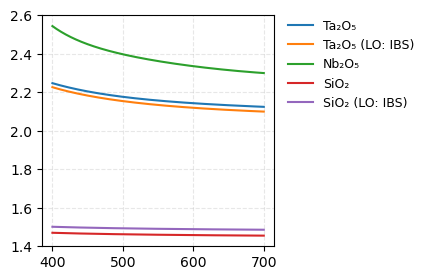

2.3452920258973924


In [2]:
Sellmeier(B, C, λ) = √(1 + sum(Bᵢ*λ^2/(λ^2-Cᵢ) for (Bᵢ, Cᵢ) in zip(B, C)))
# Refractive indices
function n_refr(material::String, λ::Float64)::Float64
    """
    SiO2: https://refractiveindex.info/?shelf=main&book=SiO2&page=Malitson
    Ta2O5: https://refractiveindex.info/?shelf=main&book=Ta2O5&page=Gao
    λ in nm
    """
    λ /= 1000 # nm to μm
    material = uppercasefirst(material)
    
    if material == "SiO2:IBS" # With IBS, values from Laseroptik
        B = [1.19261271,   0.5415, 0]
        C = [0.0079968567, 61.257, 0]
        return Sellmeier(B, C, λ)
    elseif material == "Ta2O5:IBS" # With IBS, values from Laseroptik
        B = [2.63437,   0.5694, 0.243937]
        C = [0.0355851, 0,      81]
        return Sellmeier(B, C, λ)
    elseif material == "NBK7"
        B = [1.03961212,    0.231792344,  1.01046945]
        C = [0.00600069867, 0.0200179144, 103.560653]
        return Sellmeier(B, C, λ)
    elseif material == "Suprasil" # Heraeus 
        B = [0.473115591, 0.631038719,  0.906404498]
        C = [0.012995717, 0.0041280922, 98.7685322]
        return Sellmeier(B, C, λ)
    elseif material == "SiO2"
        B = [0.6961663, 0.4079426, 0.8974794]
        C = [0.0684043, 0.1162414, 9.8961610]
        return √(1 + sum(B[i]*λ^2/(λ^2-C[i]^2) for i in 1:3)) # Not the Sellmeier formular! --> C[i]²
    elseif material == "Ta2O5" # values empiric from fit (exponential + polynomial) to data
        return 6.70419*exp(-11.1521*λ) + 2.27472 - 0.319763*λ + 0.144455*λ^2
    elseif material == "Nb2O5" # values empiric from fit (exponential + polynomial) to data, only valid between 400...800nm
        return 582.098*exp(-22.1463*λ) + 2.94173+ -1.58087*λ + 0.948068*λ^2
    elseif material in ["EthyleneGlycol", "Ethylenglykol", "EthGly", "EthyGly"]
        return 1.43
    elseif material in ["Acetone", "Aceton"]
        return 1.36
    elseif material in ["Air", "Vac", "Vacuume"]
        return 1.00
    else
        error("Material not found.")
    end
end

λ = 400:1.0:700
plt.figure(figsize=(3, 3))
plt.plot(λ, [n_refr("Ta2O5", wlen)     for wlen in λ], label="Ta₂O₅")
plt.plot(λ, [n_refr("Ta2O5:IBS", wlen) for wlen in λ], label="Ta₂O₅ (LO: IBS)")
plt.plot(λ, [n_refr("Nb2O5", wlen)     for wlen in λ], label="Nb₂O₅")
plt.plot(λ, [n_refr("SiO2", wlen)      for wlen in λ], label="SiO₂")
plt.plot(λ, [n_refr("SiO2:IBS", wlen)  for wlen in λ], label="SiO₂ (LO: IBS)")
plt.ylim(1.4, 2.6)
plt.grid(ls="--", alpha=0.3)
plt.legend(loc=1, fontsize=9, bbox_to_anchor=(1.65, 1.03), frameon=false);
println(n_refr("Nb2O5", 580.0))

In [39]:
# See also: Open-Filters Paper DOI: 10.1364/AO.47.00C219
function ReflectivityOfBraggMirror(λ::AbstractFloat, λ₀::AbstractFloat, θ₀::AbstractFloat, m_medium::String, m_substrate::String, m_high::String, m_low::String; N)
    """ Reflectivity of a Bragg mirror. Alternating layers of thickness λ₀/4 """
    θ₀ = deg2rad(θ₀)
    # n₀: Medium(e.g. Ethyl. Glyc.), ns: Substrate, Material-1, Material-2
    n₀, ns, n₁, n₂ = n_refr(m_medium, λ*1e9), n_refr(m_substrate, λ*1e9), n_refr(m_high, λ*1e9), n_refr(m_low, λ*1e9)
    n = vcat(repeat([n₁, n₂], N), n₁) # Layers. First and last material is identical
    # 
    θ     =@. asin(n₀/n  * sin(θ₀)) # propagation angle inside the layers
    θ_out =   asin(n₀/ns * sin(θ₀))
    # 
    ΔL =@. λ₀ ./ 4n # Thickness: λ/4
    k  =@. 2π/λ * n
    δ  =@. k*ΔL * cos(θ) # phase shift per layer
    # pseudo-indices
    η₀_s, ηs_s, η_s = n₀ * cos(θ₀), ns * cos(θ_out), n .* cos.(θ)
    η₀_p, ηs_p, η_p = n₀ / cos(θ₀), ns / cos(θ_out), n ./ cos.(θ) 
    # Transfer-Matrix-Generators for s- and p-pol. 
    M_s, M_p = ((
        [ cos(δᵢ)         1im*sin(δᵢ)/ηᵢ;
          1im*sin(δᵢ)*ηᵢ  cos(δᵢ)          ] for (δᵢ, ηᵢ) in zip(δ, η)
                                           ) for η in (η_s, η_p)        ) # s- and p-pol
    # Calculation for s- and p-pol.
    v₁_s, v₂_s = [η₀_s -1; η₀_s 1] * prod(M_s) * [1, ηs_s]
    R_s = abs2(v₁_s/v₂_s)
    #
    v₁_p, v₂_p = [η₀_p -1; η₀_p 1] * prod(M_p) * [1, ηs_p]
    R_p = abs2(v₁_p/v₂_p)

    R_s, R_p
end

ReflectivityOfBraggMirror (generic function with 1 method)

In [4]:
function ReflectivityOfDielectricMirror(λ, λ₀_1, λ₀_2, θ₀::AbstractFloat; medium::String, substrate::String, m_high::String, m_low::String, N1, N2)
    """ Reflectivity of an arbitrary dielectric mirror. Layer thicknesses are customized. """
    θ₀ = deg2rad(θ₀)
    # n₀: Medium(e.g. Ethyl. Glyc.), ns: Substrate, Material-1, Material-2
    n₀, ns, n₁, n₂ = n_refr(medium, λ*1e9), n_refr(substrate, λ*1e9), n_refr(m_high, λ*1e9), n_refr(m_low, λ*1e9)
    
    #----- Improved pump transmission
    # n = reverse(vcat(repeat([n₁, n₂], 38), n₁))
    # ΔL = reverse(693e-9 .* [0.75741,0.68876,0.8664,0.84454,1.51678,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.00441,0.46688,0.95273,0.59731,1.89814,1.01,1.01,1.01,1.01,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805])
    #----- Two layer pairs taken out
    # n = reverse(vcat(repeat([n₁, n₂], 36), n₁))
    # ΔL = reverse(693e-9 .* [0.75741,0.68876,0.8664,0.84454,1.51678,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.00441,0.46688,0.95273,0.59731,1.89814,1.01,1.01,1.01,1.01,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805,0.82041627,0.81211805])
    #----- Smoothing of transmission: Final
    n = reverse(repeat([n₁, n₂], 37))
    ΔL = reverse(570e-9 .* [1.52604662,1.09608991,1.62648768,0.8459486,1.34525973,1.25809304,1.35149071,1.19464964,1.25814221,1.16678573,1.36466614,1.24492899,1.32144582,1.18179031,1.20443081,1.1640676,1.27012323,1.2781804,1.28259679,1.19179742,1.21585772,1.10693806,1.22254394,1.13999445,1.32314508,1.275316,1.32821823,1.24596505,1.31922939,1.32561973,1.3852789,1.50000682,1.23586713,1.07862317,0.83633162,1.04990604,1.07313217,1.00725696,1.02343496,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.71787593,0.20910963])
    #----- Again with one additional 570nm-Pair
    # n = reverse(repeat([n₁, n₂], 38))
    # ΔL = reverse(570e-9 .* [1.52604662,1.09608991,1.62648768,0.8459486,1.34525973,1.25809304,1.35149071,1.19464964,1.25814221,1.16678573,1.36466614,1.24492899,1.32144582,1.18179031,1.20443081,1.1640676,1.27012323,1.2781804,1.28259679,1.19179742,1.21585772,1.10693806,1.22254394,1.13999445,1.32314508,1.275316,1.32821823,1.24596505,1.31922939,1.32561973,1.3852789,1.50000682,1.23586713,1.07862317,0.83633162,1.04990604,1.07313217,1.00725696,1.02343496,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.71787593,0.20910963])
    
    #----- only 570nm part
    # n = reverse(repeat([n₁, n₂], 19))
    # ΔL = reverse(570e-9 .* [1.07313217,1.00725696,1.02343496,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.71787593,0.20910963])
    # n = reverse(repeat([n₁, n₂], 18))
    # ΔL = reverse(570e-9 .* [1.52604662,1.09608991,1.62648768,0.8459486,1.34525973,1.25809304,1.35149071,1.19464964,1.25814221,1.16678573,1.36466614,1.24492899,1.32144582,1.18179031,1.20443081,1.1640676,1.27012323,1.2781804,1.28259679,1.19179742,1.21585772,1.10693806,1.22254394,1.13999445,1.32314508,1.275316,1.32821823,1.24596505,1.31922939,1.32561973,1.3852789,1.50000682,1.23586713,1.07862317,0.83633162,1.04990604])

    #----- Trying Stuff out with Nb2O5
    # n = reverse(vcat(repeat([n₁, n₂], 28), n₁))
    # ΔL = reverse(550e-9 .* vcat(repeat([1.35,], 28), repeat([1.0,], 29)))
    
    ΔL ./= 4n
    
    # n1 = repeat([n₁, n₂], N1)
    # n2 = vcat(repeat([n₁, n₂], N2), n₁)
    # n = vcat(n1, n2)
    # 
    θ =@. asin(n₀ / n * sin(θ₀)) # propagation angle inside the layers
    θ_out = asin(n₀/ns * sin(θ₀))
    # 
    # ΔL1 = λ₀_1 ./ 4n1
    # ΔL2 = λ₀_2 ./ 4n2
    # ΔL = vcat(ΔL1, ΔL2)
    
    k =@. 2π/λ * n
    δ =@. k*ΔL * cos(θ) # phase shift per layer
    # pseudo-indices
    η₀_s, ηs_s, η_s = n₀ * cos(θ₀), ns * cos(θ_out), n .* cos.(θ)
    η₀_p, ηs_p, η_p = n₀ / cos(θ₀), ns / cos(θ_out), n ./ cos.(θ) 
    # Transfer-Matrix-Generators for s- and p-pol. 
    M_s, M_p = ((
        [ cos(δᵢ)         1im*sin(δᵢ)/ηᵢ;
          1im*sin(δᵢ)*ηᵢ  cos(δᵢ)          ] for (δᵢ, ηᵢ) in zip(δ, η)
                                           ) for η in (η_s, η_p)        ) # s- and p-pol
    # Calculation for s- and p-pol.
    v₁_s, v₂_s = [η₀_s -1; η₀_s 1] * prod(M_s) * [1, ηs_s]
    R_s = abs2(v₁_s/v₂_s)
    #
    v₁_p, v₂_p = [η₀_p -1; η₀_p 1] * prod(M_p) * [1, ηs_p]
    R_p = abs2(v₁_p/v₂_p)
    
#     for (η₀, ηs, η) in [(η₀_s, ηs_s, η_s), (η₀_p, ηs_p, η_p)]
#         M = ([ cos(δₓ)         1im*sin(δₓ)/ηₓ;
#                1im*sin(δₓ)*ηₓ  cos(δₓ)          ] for (δₓ, ηₓ) in zip(δ, η))
#         v₁, v₂ = [η₀ -1; η₀ 1] * prod(M) * [1, ηs]
#         R = abs2(v₁/v₂)
#     end
    #
    R_s, R_p
end

ReflectivityOfDielectricMirror (generic function with 1 method)

In [14]:
λ_ = 400.0 : 1 : 700.0
λ₀ = 550.0
θ_ = 0.0 : 1 : 90.0
R_raw = [ReflectivityOfBraggMirror(λ*1e-9, λ₀*1e-9, θ, "EthGly", "SiO2", "Ta2O5", "SiO2:IBS", N=19) for θ in θ_, λ in λ_]
# R_raw = [ReflectivityOfDielectricMirror(λ*1e-9, 570e-9, 693e-9, θ, medium="EthGly", substrate="SiO2", m_high="Ta2O5:IBS", m_low="SiO2:IBS", N1=19, N2=19) for θ in θ_, λ in λ_]
R_s, R_p = [r[1] for r in R_raw], [r[2] for r in R_raw] #  s- and p-polarization
T_s, T_p = 1 .- R_s, 1 .- R_p
T = (T_s + T_p)/2 # Transmission
size(R_raw), size(R_s)

((91, 301), (91, 301))

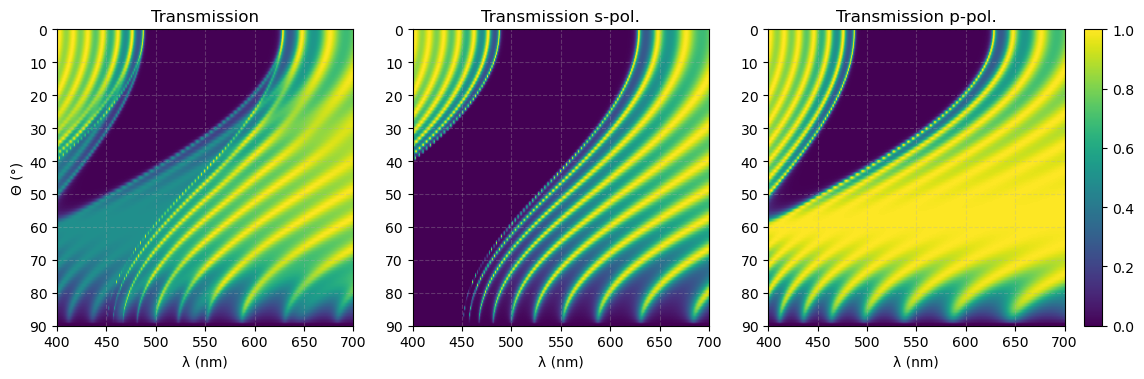

In [40]:
tmp = nothing
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
for (ax, Trans, t) in zip(axs, [T, T_s, T_p], ["Transmission", "Transmission s-pol.", "Transmission p-pol."])
    tmp = ax.imshow(Trans,
        extent = (extrema(λ_)..., reverse(extrema(θ_))...),
        aspect = -(extrema(λ_)...)/-(extrema(θ_)...),
        vmin = 0, vmax = 1
    )
    ax.set(xlabel="λ (nm)", title=t)
    ax.grid(ls="--", alpha=0.3)
end
axs[1].set_ylabel("Θ (°)")

cax = fig.add_axes([axs[3].get_position().x1+0.015, axs[3].get_position().y0, 0.014, axs[3].get_position().height]) # x, y, width, height
plt.colorbar(tmp, cax=cax);

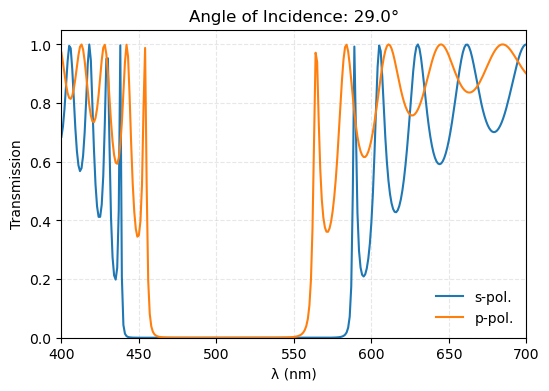

In [41]:
angle_idx = argmin(abs.(θ_ .- 29)) # Angle close to...
plt.figure(figsize=(6, 4))
plt.subplot(title=string("Angle of Incidence: ", θ_[angle_idx], "°"), xlabel="λ (nm)", ylabel="Transmission")
plt.plot(λ_, T_s[angle_idx, :], label="s-pol.")
plt.plot(λ_, T_p[angle_idx, :], label="p-pol.")
#plt.hlines(5e-6, 400, 700)
# plt.vlines(633, 0, 1, color="k")
plt.grid(ls="--", alpha=0.3); plt.legend(frameon=false);
plt.xlim(extrema(λ_));
plt.ylim(0)
minimum(T_s[angle_idx, :])

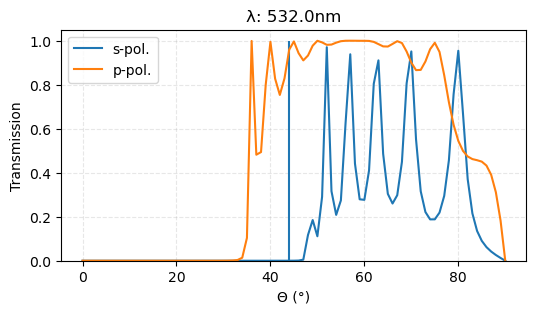

In [38]:
λ_idx = argmin(abs.(λ_ .- 532))
plt.figure(figsize=(6, 3))
plt.plot(θ_, T_s[:, λ_idx], label="s-pol.")
plt.plot(θ_, T_p[:, λ_idx], label="p-pol.")
plt.title(string("λ: ", λ_[λ_idx], "nm"))
plt.xlabel("Θ (°)")
plt.ylabel("Transmission")
plt.grid(ls="--", alpha=0.3)
plt.vlines(44, 0, 1)
plt.ylim(bottom=0)
plt.legend();
#plt.savefig("tmp2.svg")

In [9]:
# Write values to file
# open("Transmission_LO_Broadband_Simulation_Erik.dat", "w") do f
#     # write(f, "# Materials: Nb2O5 and SiO2\r\n# Center wavelength: 550nm\r\n# 13 Stacks + 1\r\n# wlen\tT\r\n")
#     for (wlen, trans) in zip(λ_, T_s[1, :])
#         write(f, format("{:.1f}\t{:.4e}\r\n", wlen, trans))
#     end
# end
# for (i, angle) in enumerate(θ_)
#     write(f, format("# Angle of incidence {}°\r\n", angle))
#     write(f, "# wlen\tTs\t\t\t\tTp\r\n")
#     for (wlen, ts, tp) in zip(λ_, T_s[i, :], T_p[i, :])
#         write(f, string(wlen, "\t", @sprintf("%e", ts), "\t", @sprintf("%e", tp), "\r\n"))
#     end
# end

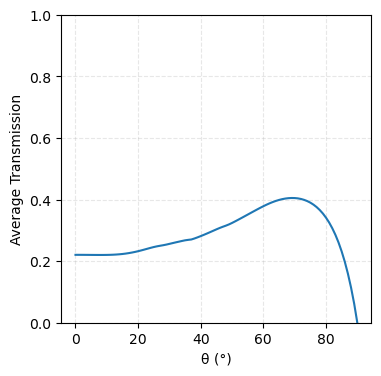

PyObject Text(24.000000000000007, 0.5, 'Average Transmission')

In [10]:
using Statistics
# Losses(λ, Θ) = ∫ T(λ, Θ) * f(λ)  sin(Θ)dΘ dλ
losses = reshape(mean(T, dims=2), length(θ_))
plt.figure(figsize=(4, 4))
plt.plot(θ_, losses) # dims=1: vertical, 2: horizontal, reshape because otherwise it's a 1xN Matrix...
plt.ylim(0, 1)
plt.grid(ls="--", alpha=0.3)
plt.xlabel("θ (°)")
plt.ylabel("Average Transmission")

In [11]:
using DelimitedFiles
#writedlm("T_550_585.dat", [θ_ losses])

Min: 0.5950323785934506 Max: 0.9434842207871754


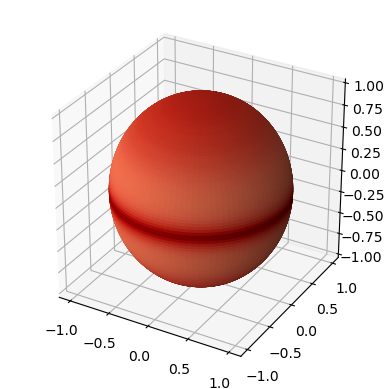

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x000000003B0D1788>

In [12]:
using PyCall
np = pyimport("numpy")
interp1d = pyimport("scipy.interpolate").interp1d
pyimport("mpl_toolkits.mplot3d").Axes3D

surface = interp1d(θ_, losses, kind="cubic", bounds_error=false, fill_value=0)

theta, phi = np.linspace(0, π, 100), np.linspace(0, 2π, 100)
theta, phi = np.meshgrid(theta, phi)
x, y, z =@. sin(theta) * cos(phi), sin(theta) * sin(phi), cos(theta)

fcolors = 1 .- (surface(rad2deg.(theta)) + surface(rad2deg.(π .- theta)))
println("Min: ", minimum(fcolors), " Max: ", maximum(fcolors)); flush(stdout)
fmax, fmin = 1, 0 #maximum(fcolors), minimum(fcolors)
fcolors = (fcolors .- fmin)/(fmax - fmin)

fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=matplotlib.cm.OrRd(fcolors))
#ax.set_axis_off()

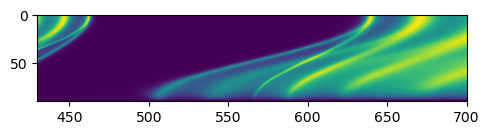

In [13]:
plt.figure(figsize=(5, 3))
plt.imshow(T,
        extent = (extrema(λ_)..., reverse(extrema(θ_))...),
        aspect = 0.6,
        vmin = 0, vmax = 1, cmap="viridis")
#plt.colorbar()
#plt.xlabel("λ (nm)")
#plt.xticks([])
#plt.ylabel("θ (°)")
plt.tight_layout()
#plt.savefig("test.svg")